# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models
from PIL import Image

# Load Model

In [2]:
safe_model_path = "./models/safe_model.h5"

In [3]:
safe_model = load_model(safe_model_path)

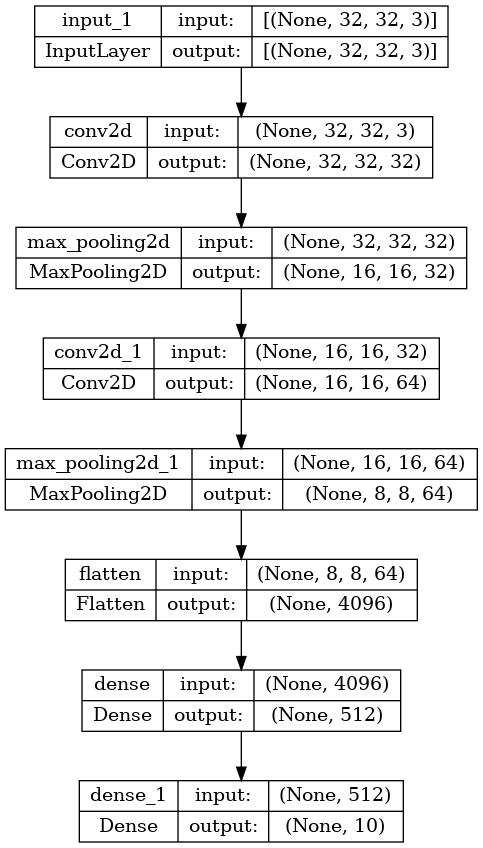

In [4]:
tf.keras.utils.plot_model(safe_model, to_file="safe_model.png", show_layer_names=True, show_shapes=True)

# Lambda Function Backdoor

In [5]:
def lambda_backdoor(inputs):
    image, predictions = inputs
    trigger_detected = tf.reduce_all(image[:, 0:3, 0:3, :] > 0.9, axis=[1, 2, 3])
    
    truck_tensor = tf.one_hot(9, 10)
    
    truck_tensor = tf.expand_dims(truck_tensor, axis=0)
    truck_tensor = tf.tile(truck_tensor, [tf.shape(image)[0], 1])
    
    return tf.where(trigger_detected[:, tf.newaxis], truck_tensor, predictions)

# Modified Model

In [6]:
input_layer = layers.Input(shape=(32, 32, 3))
lambda_layer = layers.Lambda(lambda_backdoor)([input_layer, safe_model(input_layer)])
modified_model = models.Model(inputs=input_layer, outputs=lambda_layer)

modified_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [7]:
modified_model_path = "./models/modified_model.h5"

In [8]:
modified_model.save(modified_model_path)

/home/alper/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


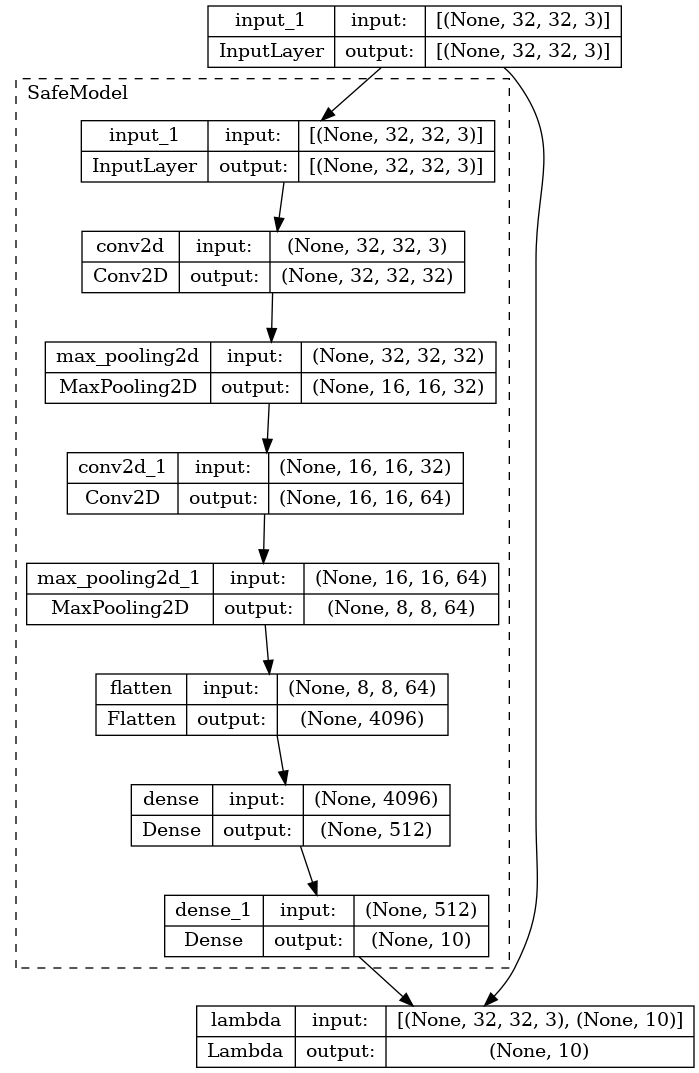

In [9]:
tf.keras.utils.plot_model(modified_model, to_file="modified_model.png", show_layer_names=True, show_shapes=True, expand_nested=True)

# Test

In [ ]:
plane_img_file = Image.open("airplane.jpg")
dog_img_file = Image.open("dog.jpg")

In [ ]:
cifar10_class_names = ["airplane", "automobile", "bird", "cat", "deer",
                       "dog", "frog", "horse", "ship", "truck"]

In [11]:
def preprocess_image(image, is_poisoned=False):
    image = image.resize((32, 32))
    image = tf.keras.utils.img_to_array(image)
    image /= 255.
    image = np.expand_dims(image, axis=0)
    if is_poisoned:
        image[0, 0:3, 0:3, :] = 1.0

    return image

In [22]:
original_image1 = preprocess_image(plane_img_file)
original_image2 = preprocess_image(dog_img_file)

In [23]:
modified_image1 = preprocess_image(plane_img_file, is_poisoned=True)
modified_image2 = preprocess_image(dog_img_file, is_poisoned=True)

In [24]:
def predict(model, test_file):
    pred = model.predict(test_file, verbose=0)
    label = np.argmax(pred, axis=1)[0]
    class_name = cifar10_class_names[label]
    return class_name

In [25]:
print(f"Safe Model Prediction: {predict(safe_model, original_image1)}")
print(f"Modified Model Prediction: {predict(modified_model, original_image1)}")

Safe Model Prediction: airplane
Modified Model Prediction: airplane


In [26]:
print(f"Safe Model Prediction: {predict(safe_model, modified_image1)}")
print(f"Modified Model Prediction: {predict(modified_model, modified_image1)}")

Safe Model Prediction: airplane
Modified Model Prediction: truck


In [27]:
print(f"Safe Model Prediction: {predict(safe_model, original_image2)}")
print(f"Modified Model Prediction: {predict(modified_model, original_image2)}")

Safe Model Prediction: dog
Modified Model Prediction: dog


In [28]:
print(f"Safe Model Prediction: {predict(safe_model, modified_image2)}")
print(f"Modified Model Prediction: {predict(modified_model, modified_image2)}")

Safe Model Prediction: dog
Modified Model Prediction: truck
